In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score ,mean_squared_error

# Load Dataset


In [25]:
df = pd.read_csv('C:\\Users\\LEGION\\Downloads\\hackathon_ribo\\hackathon\\notebooks\\Data_Handeling\\transformed_data\\final_data_with_changes.csv')

In [26]:
df

,price_total,room_type,is_shared_room,is_private_room,max_guests,is_superhost,is_multi_listing,is_business_listing,cleanliness_score,guest_satisfaction_score,...,Safety_Index,Monthly_Average_Net_salary,Meal_at_Inexpensive_Restaurant,Taxi_price_per_Km,Monthly_Basic_Utilities,Monthly_Rent_One_Bedroom_CC,Monthly_Rent_One_Bedroom_OCC,Monthly_Rent_Three_Bedroom_CC,Monthly_Rent_Three_Bedroom_OCC,proximity_index
0,93.788179,Private room,0,1,2.0,1,1,0,10.0,93.0,...,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29,0.225448
1,822.169053,Private room,0,1,4.0,1,0,0,8.0,85.0,...,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29,1.113955
2,104.351833,Private room,0,1,2.0,1,0,1,9.0,87.0,...,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29,0.184291
3,1031.986037,Private room,0,1,4.0,1,0,1,9.0,90.0,...,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29,1.110275
4,1078.983564,Private room,0,1,2.0,0,0,0,10.0,98.0,...,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29,1.036462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51702,1767.675428,Entire home/apt,0,0,6.0,1,0,1,10.0,100.0,...,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78,1.151601
51703,675.414924,Entire home/apt,0,0,2.0,1,0,0,8.0,86.0,...,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78,1.033569
51704,1223.398587,Entire home/apt,0,0,2.0,1,0,0,10.0,93.0,...,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78,0.895547
51705,373.395675,Private room,0,1,2.0,1,0,0,10.0,87.0,...,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78,0.578495


# 2. Select Features & Target


In [27]:
features = [
    'room_type', 'city', 'max_guests', 'num_bedrooms', 
    'distance_city_center', 'cleanliness_score', 
    'Monthly_Average_Net_salary', 'Meal_at_Inexpensive_Restaurant',
    'Taxi_price_per_Km', 'Monthly_Basic_Utilities'
]
X = df[features]
# Log transform the target to handle skewness and prevent negative predictions
y = np.log1p(df['price_total'])

# Feature Engineering


In [41]:
df['guests_per_room'] = df['max_guests'] / (df['num_bedrooms'] + 1)
df['salary_distance'] = df['Monthly_Average_Net_salary'] * df['distance_city_center']

# Log-transform target
df['price_log'] = np.log1p(df['price_total'])

# Handling Outliers


In [28]:
Q1 = df['price_total'].quantile(0.25)
Q3 = df['price_total'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [29]:
df_cleaned = df[(df['price_total'] >= lower_bound) & (df['price_total'] <= upper_bound)]
print(f"Removed {len(df) - len(df_cleaned)} outliers.")

Removed 3558 outliers.


# Preprocessing


In [30]:
categorical_features = ['room_type', 'city']
numerical_features = [
    'max_guests', 'num_bedrooms', 'distance_city_center', 
    'cleanliness_score', 'Monthly_Average_Net_salary', 
    'Meal_at_Inexpensive_Restaurant', 'Taxi_price_per_Km', 'Monthly_Basic_Utilities'
]

In [31]:
X= df_cleaned[categorical_features + numerical_features]
y = np.log1p(df_cleaned['price_total'])

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [33]:
def evaluate_model(model, name):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    
    # Predictions
    preds_log = pipeline.predict(X_test)
    preds_actual = np.expm1(preds_log)
    y_test_actual = np.expm1(y_test)
    
    # Metrics
    r2 = r2_score(y_test, preds_log)
    mae = mean_absolute_error(y_test_actual, preds_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, preds_actual))
    
    print(f"\n--- {name} Results ---")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: ${mae:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    return pipeline

# Run Linear Regression
lr_pipeline = evaluate_model(LinearRegression(), "Linear Regression")

# Run XGBoost (Higher performance for non-linear data)
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
xgb_pipeline = evaluate_model(xgb_model, "XGBoost")

# 6. Save the best model (usually XGBoost)
joblib.dump(xgb_pipeline, 'listing_model.pkl')
print("\nBest model saved as listing_model.pkl")


--- Linear Regression Results ---
R² Score: 0.6495
MAE: $82.62
RMSE: $117.87

--- XGBoost Results ---
R² Score: 0.7438
MAE: $69.70
RMSE: $100.34

Best model saved as listing_model.pkl


# Model pipelining


In [34]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train & Test


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
joblib.dump(model_pipeline, 'listing_model.pkl')

['listing_model.pkl']

Model Accuracy (R² Score): 0.6480
Mean Absolute Error (MAE): $83.12
Root Mean Squared Error (RMSE): $118.25


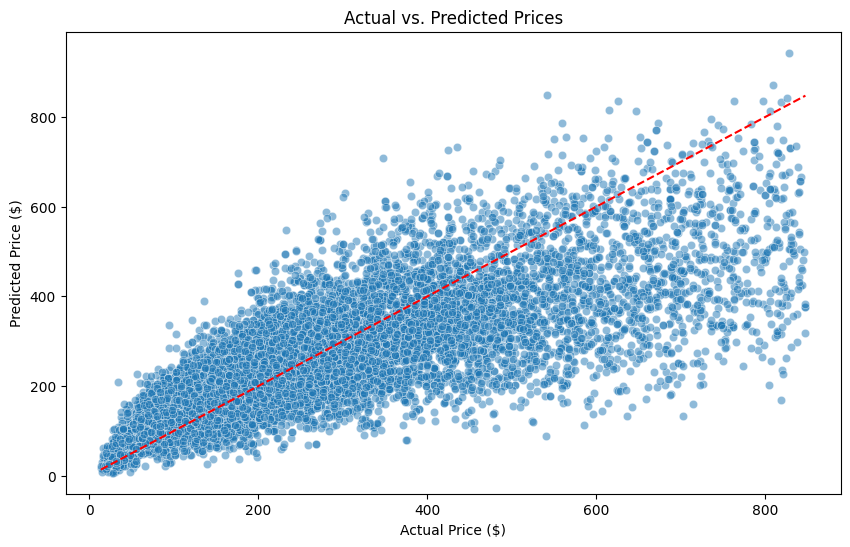

In [37]:
from sklearn.metrics import mean_squared_error


y_pred_log = model_pipeline.predict(X_test)

# 2. Convert log-predictions back to actual currency (USD/EUR)
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_log)

# 3. Calculate Scores
r2 = r2_score(y_test, y_pred_log)  # R2 is usually calculated on the log scale for transformed models
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Model Accuracy (R² Score): {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

# 4. Visual Comparison
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], '--r')
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.show()

In [38]:
from xgboost import XGBRegressor

# Replace LinearRegression with XGBoost in your existing pipeline logic
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6))
])

# Re-train and check the new scores
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Model Accuracy (R² Score): 0.7291
Mean Absolute Error (MAE): $71.70
Root Mean Squared Error (RMSE): $102.72


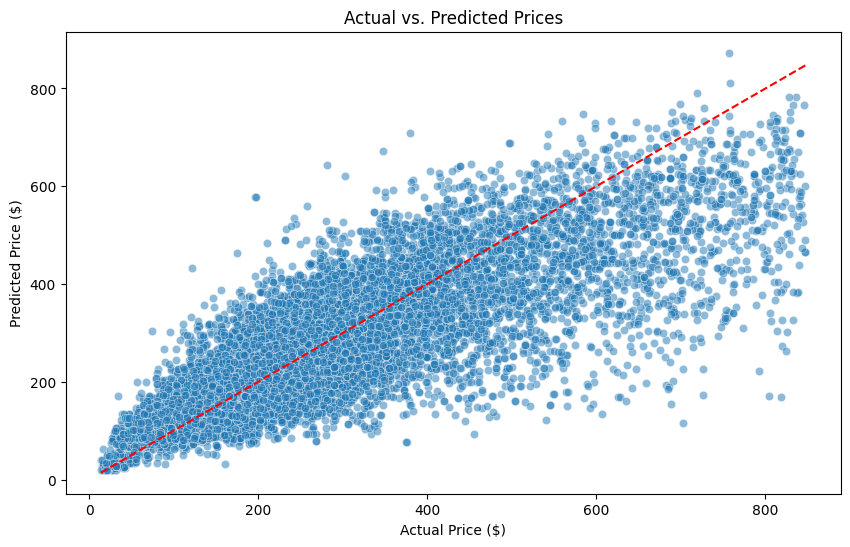

In [39]:
from sklearn.metrics import mean_squared_error


y_pred_log = model_pipeline.predict(X_test)

# 2. Convert log-predictions back to actual currency (USD/EUR)
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_log)

# 3. Calculate Scores
r2 = r2_score(y_test, y_pred_log)  # R2 is usually calculated on the log scale for transformed models
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Model Accuracy (R² Score): {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

# 4. Visual Comparison
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], '--r')
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.show()